In [1]:
import os
import sys
p = '..'
while not os.path.isdir(p + '/notebooks'):
    p += '/..'
sys.path.append(p) # for import src

import os
import cloudpickle
import lzma
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import lightgbm as lgb
import talib
import joblib

import src
from src.ml_utils import (
    fetch_ohlcv, 
    visualize_result, 
    normalize_position, 
    calc_position_cv2,
    get_feature_columns,
    get_symbols,
    unbiased_rank,
    ewm_finite,
)
from src.data_fetcher import DataFetcher
cloudpickle.register_pickle_by_value(src) # for model portability

os.environ["USE_JOBLIB_MEMORY"] = "1"

def get_joblib_memory():
    if os.getenv('USE_JOBLIB_MEMORY'):
        return joblib.Memory('/tmp/alphapool_joblib_memory', verbose=0)
    else:
        return joblib.Memory(None, verbose=0)

model_name = '20220910_beta'

In [2]:
# symbols = os.getenv('ALPHAPOOL_SYMBOLS').split(',') # 売買代金が多く、古いもの
# symbols += 'DOGE,SFP,DYDX,AXS,CHZ,TRX,MASK,ETC,LTC,1000SHIB,C98,SAND,SUSHI,NEAR,FIL'.split(',')
# symbols += 'SFP,DYDX,AXS,TRX,MASK,ETC,LTC,1000SHIB,C98,SAND,SUSHI,NEAR,FIL'.split(',')
symbols = ['ADA', 'ATOM', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'XRP', 'ETC', 'LTC'] # binance, bybit, okex
# symbols = ['ADA', 'ATOM', 'BNB', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'XRP', 'ETC', 'LTC'] # binance, bybit
# symbols = ['ADA', 'ATOM', 'BNB', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'XRP'] # binance, bybit

provider_configs = [
    {
        'provider': 'bigquery',
        'options': {
            'table': 'binance_ohlcv',
            'symbols': ['{}USDT'.format(x) for x in symbols],
        }
    },
]

dfs = DataFetcher(memory=get_joblib_memory()).fetch(
    provider_configs=provider_configs, 
    min_timestamp=None,
)

for df in dfs:
    display(df)

def merge_data(dfs):
    df = dfs[0]
    df['symbol'] = df['symbol'].str.replace('USDT', '')
    df = df.set_index(['timestamp', 'symbol']).sort_index()
    return df

df = merge_data(dfs)

def merge_kraken_data(df):
    symbols = list(df.index.get_level_values('symbol').unique())
    
    train_provider_configs = [
        {
            'provider': 'bigquery',
            'options': {
                'table': 'kraken_historical_ohlcvt',
                'symbols': symbols,
            }
        },
    ]

    dfs = DataFetcher(memory=get_joblib_memory()).fetch(
        provider_configs=train_provider_configs, 
        min_timestamp=None,
    )
    df_kraken = dfs[0].set_index(['timestamp', 'symbol'])

    df = df.copy()
    df['extended'] = False
    df = pd.concat([df, df_kraken])
    df['extended'] = df['extended'].fillna(True)
    df = df[['op', 'hi', 'lo', 'cl', 'volume', 'twap_5m', 'extended']]
    df = df.loc[~df.index.duplicated()]
    df = df.sort_index()
    return df.copy()

df = merge_kraken_data(df)

df = df.dropna()
df.to_pickle('/tmp/df_binance_ohlcv_extended.pkl')
display(df)

,timestamp,symbol,op,hi,lo,cl,volume,amount,trades,buy_volume,...,twap,twap_5m,cl_std,cl_diff_std,hi_twap,lo_twap,hi_op_max,lo_op_min,ln_hi_lo_mean,ln_hi_lo_sqr_mean
0,2020-01-15 12:00:00+00:00,BTCUSDT,8738.0600,8800.0000,8727.0000,8771.6900,8.946680e+03,7.850456e+07,13798.0,4.436936e+03,...,8775.769667,8778.084167,14.040439,6.881349,8780.483500,8771.374500,5.326833,-3.782167,0.001038,1.380802e-06
1,2020-01-05 05:00:00+00:00,BTCUSDT,7456.4000,7465.0500,7445.0000,7457.4800,2.471459e+03,1.842765e+07,5214.0,1.156706e+03,...,7455.926000,7456.212500,4.514219,3.336579,7457.473167,7454.343833,1.557333,-1.572000,0.000420,2.715494e-07
2,2020-01-21 20:00:00+00:00,BTCUSDT,8536.1100,8728.3000,8534.0000,8724.3300,2.086066e+04,1.809620e+08,40863.0,1.152243e+04,...,8687.885833,8695.270000,33.958820,13.051842,8694.736000,8678.471167,10.014833,-6.250000,0.001875,6.025309e-06
3,2019-12-28 16:00:00+00:00,BTCUSDT,7300.4100,7329.0000,7273.3500,7317.0000,6.115423e+03,4.467909e+07,10777.0,2.834010e+03,...,7311.903000,7312.781667,12.521396,5.569986,7314.868333,7308.164500,3.294667,-3.409167,0.000917,1.126881e-06
4,2020-01-11 16:00:00+00:00,BTCUSDT,8101.6900,8186.2300,8070.5600,8172.7500,1.084198e+04,8.823840e+07,22418.0,5.702753e+03,...,8137.871333,8140.311667,27.135540,8.615129,8143.158333,8131.301333,6.621833,-5.235167,0.001457,2.541703e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241335,2022-11-18 23:00:00+00:00,MATICUSDT,0.8765,0.8837,0.8739,0.8793,1.330728e+07,1.170022e+07,20066.0,7.011664e+06,...,0.877853,0.877858,0.002375,0.000731,0.878395,0.877350,0.000568,-0.000477,0.001190,1.773858e-06
241336,2022-11-17 07:00:00+00:00,MATICUSDT,0.8758,0.8916,0.8746,0.8906,3.933431e+07,3.473189e+07,62837.0,2.119871e+07,...,0.883158,0.883150,0.004732,0.001568,0.884153,0.882043,0.001240,-0.000870,0.002390,7.167882e-06
241337,2022-11-12 22:00:00+00:00,MATICUSDT,0.9451,0.9528,0.9407,0.9528,1.276405e+07,1.208034e+07,25289.0,6.453293e+06,...,0.947212,0.947800,0.002749,0.001172,0.947800,0.946328,0.000713,-0.000758,0.001555,3.148365e-06
241338,2022-11-08 08:00:00+00:00,MATICUSDT,1.1692,1.1693,1.1414,1.1439,6.692157e+07,7.713176e+07,110827.0,3.172108e+07,...,1.151658,1.150933,0.005267,0.002202,1.153650,1.149947,0.001592,-0.002112,0.003214,1.128696e-05


op          hi         lo  \
timestamp                 symbol                                      
2013-10-06 21:00:00+00:00 BTC      122.00000   122.00000   122.0000   
2013-10-07 20:00:00+00:00 BTC      123.61000   123.61000   123.6100   
2013-10-08 02:00:00+00:00 BTC      123.91000   123.91000   123.9000   
2013-10-08 05:00:00+00:00 BTC      124.19000   124.19000   124.1800   
2013-10-09 09:00:00+00:00 BTC      124.01687   124.01687   123.8400   
...                                      ...         ...        ...   
2022-11-20 22:00:00+00:00 ETH     1142.20000  1153.93000  1133.8000   
                          LINK       5.74700     5.80300     5.7000   
                          LTC       60.89000    62.35000    60.3300   
                          MATIC      0.80410     0.81470     0.7981   
                          XRP        0.36180     0.36590     0.3594   

                                         cl        volume      twap_5m  \
timestamp                 symbol                                         
2013-10-06 21:00:00+00:00 BTC      122.0000  1.000000e-01   122.000000   
2013-10-07 20:00:00+00:00 BTC      123.6100  1.000000e-01   123.610000   
2013-10-08 02:00:00+00:00 BTC      123.9000  1.991600e+00   123.900000   
2013-10-08 05:00:00+00:00 BTC      124.1800  2.000000e+00   124.180000   
2013-10-09 09:00:00+00:00 BTC      123.8400  2.823000e+00   123.840000   
...                                     ...           ...          ...   
2022-11-20 22:00:00+00:00 ETH     1142.3900  3.578812e+05  1145.998333   
                          LINK       5.7900  2.226790e+06     5.784333   
                          LTC       61.8800  5.560289e+05    61.760000   
                          MATIC      0.8104  3.171846e+07     0.810583   
                          XRP        0.3639  8.889304e+07     0.364158   

                                  extended  
timestamp                 symbol            
2013-10-06 21:00:00+00:00 BTC         True  
2013-10-07 20:00:00+00:00 BTC         True  
2013-10-08 02:00:00+00:00 BTC         True  
2013-10-08 05:00:00+00:00 BTC         True  
2013-10-09 09:00:00+00:00 BTC         True  
...                                    ...  
2022-11-20 22:00:00+00:00 ETH        False  
                          LINK       False  
                          LTC        False  
                          MATIC      False  
                          XRP        False  

[420675 rows x 7 columns]

In [3]:
# based on 20220910_eda

import numba

def signed_rsi_sma(x, timeperiod=14):
    v = x.diff(1).fillna(0)
    return v.rolling(timeperiod, 1).mean() / (1e-37 + v.abs().rolling(timeperiod, 1).mean())

def calc_features(df):
    dfs = []
    for symbol, df_symbol in df.groupby('symbol'):
        dfs.append(calc_features_single(df_symbol))
    df = pd.concat(dfs).sort_index()

    df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
    df['beta'] = df.groupby('symbol')['ln_cl_diff'].transform(lambda x: x.rolling(24 * 30, 1).corr(df.loc[x.index, 'ln_cl_diff_mean'])).fillna(0).clip(0.1, 2.0)

    # ret_mean = df.groupby('timestamp')['ret'].transform('mean')
    dfs = [
        df,
        # (unbiased_rank(df.groupby('timestamp')['ret']) - 0.5).rename('ret_rank'),
        # (df['ret'] - df['beta'] * ret_mean).rename('ret_beta'),
    ]
    for col in get_feature_columns(df):
        # df[col] = unbiased_rank(df.groupby('timestamp')[col]) - 0.5
        # df[col + '_rank'] = unbiased_rank(df.groupby('timestamp')[col]) - 0.5
        feature_mean = df.groupby('timestamp')[col].transform('mean')
        dfs += [
            (2 * unbiased_rank(df.groupby('timestamp')[col]) - 1).rename(col + '_symbolrank'),
            (df[col] - df['beta'] * feature_mean).rename(col + '_symbolbeta'),
        ]
    df = pd.concat(dfs, axis=1)

    return df

def calc_features_single(df):
    df = df.copy()

    high = df['hi']
    low = df['lo']
    close = df['cl']
    volume = df['volume']
    df['ln_cl'] = np.log(df['cl'])
    df['ln_hi'] = np.log(df['hi'])
    df['ln_lo'] = np.log(df['lo'])
    df['ln_hilo'] = 0.5 * (df['ln_hi'] + df['ln_lo'])
    df['ln_cl_diff'] = df['ln_cl'].diff(1).fillna(0)
    
    def adx(t):
        return (talib.ADX(high, low, close, timeperiod=t) / 100).fillna(0)

    def adxr(t):
        return (talib.ADXR(high, low, close, timeperiod=t) / 100).fillna(0)

    def rsi(t):
        return signed_rsi_sma(close, timeperiod=t).fillna(0)

    def rsi_hilo(t):
        return signed_rsi_sma(0.5 * (high + low), timeperiod=t).fillna(0)

    def rsi_volume(t):
        return signed_rsi_sma(volume, timeperiod=t).fillna(0)

    def aroon_down(t):
        return (talib.AROON(high, low, timeperiod=t)[0] / 100).fillna(0)
    def aroon_up(t):
        return (talib.AROON(high, low, timeperiod=t)[1] / 100).fillna(0)

    def aroonosc(t):
        return (talib.AROONOSC(high, low, timeperiod=t) / 100).fillna(0)

    def cci(t):
        return talib.CCI(high, low, close, timeperiod=t).fillna(0)

    def cmo(t):
        return talib.CMO(close, timeperiod=t).fillna(0)

    def dx(t):
        return (talib.DX(high, low, close, timeperiod=t) / 100).fillna(0)

    def mfi(t):
        return (talib.MFI(high, low, close, volume, timeperiod=t) / 50 - 1).fillna(0)

    def trix(t):
        return talib.TRIX(close, timeperiod=t).fillna(0)

    def atr(t):
        return talib.ATR(high, low, close, timeperiod=t).fillna(0)

    def natr(t):
        return talib.NATR(high, low, close, timeperiod=t).fillna(0)

    def ma_kairi(t):
        return df['ln_cl'] - df['ln_cl'].rolling(t, 1).mean()

    def mid_kairi(t):
        return df['ln_cl'] - 0.5 * (df['ln_hi'].rolling(t, 1).max() + df['ln_lo'].rolling(t, 1).min())

    def median_kairi(t):
        return df['ln_cl'] - df['ln_cl'].rolling(t, 1).median()

    def zscore(t):
        return ((df['ln_cl'] - df['ln_cl'].rolling(t, 1).mean()) / df['ln_cl'].rolling(t, 1).std()).fillna(0)

    def volume_corr(t):
        return df['volume'].rolling(t, 1).corr(df['cl']).fillna(0)

    def range_pos_general(x, t):
        hi = x.rolling(t, 1).max()
        lo = x.rolling(t, 1).min()
        return (2 * (x - lo) / (hi - lo) - 1).fillna(0)

    def range_pos(t):
        hi = df['ln_hi'].rolling(t, 1).max()
        lo = df['ln_lo'].rolling(t, 1).min()
        return (2 * (df['ln_cl'] - lo) / (hi - lo) - 1).fillna(0)

    def range_pos_rank(t):
        return skew_ratio(df['ln_cl'], df['ln_cl'], np.ones(df.shape[0]), t)

    def obv_rsi(t):
        return signed_rsi_sma(talib.OBV(close, volume), timeperiod=t).fillna(0)

    def ad_rsi(t):
        return signed_rsi_sma(talib.AD(high, low, close, volume), timeperiod=t).fillna(0)
    
    def bwmfi_rsi(t):
        bwmfi = (df['hi'] - df['lo']) / (1 + df['volume'])
        return signed_rsi_sma(bwmfi, timeperiod=t).fillna(0)

    def macdsignal(t):
        return talib.MACDEXT(df['ln_cl'], fastperiod=int(max(2, t / 26.0 * 12)), slowperiod=max(2, t), signalperiod=int(max(2, t / 26.0 * 9)))[1].fillna(0)

    def stoch(t):
        k, d = talib.STOCH(high, low, close, fastk_period=t, slowk_period=int(max(2, t / 5.0 * 3)), slowd_period=int(max(2, t / 5.0 * 3)))
        return (k / 50 - 1).fillna(0), (d / 50 - 1).fillna(0)

    def stochf(t):
        k, d = talib.STOCHF(high, low, close, fastk_period=t, fastd_period=int(max(2, t / 5.0 * 3)))
        return (k / 50 - 1).fillna(0), (d / 50 - 1).fillna(0)

    def stochrsi(t):
        k, d = talib.STOCHRSI(close, timeperiod=t, fastk_period=int(max(2, t / 14.0 * 5)), fastd_period=int(max(2, t / 14.0 * 3)))
        return (k / 50 - 1).fillna(0), (d / 50 - 1).fillna(0)

    def ultosc(t):
        return (talib.ULTOSC(high, low, close, timeperiod1=max(2, t // 4), timeperiod2=max(2, t // 2), timeperiod3=t) / 50 - 1).fillna(0)

    def volume_ratio(t):
        return ((np.sign(close.diff(1).fillna(0)) * volume).rolling(t, 1).sum() / volume.rolling(t, 1).sum()).fillna(0)

    @numba.njit
    def do_skew_ratio(ref_price, price, weight, t):
        n = ref_price.shape[0]
        y = ref_price.copy()
        for i in range(n):
            price_slice = price[max(0, i - t + 1):i + 1]
            weight_slice = weight[max(0, i - t + 1):i + 1]
            y[i] = np.sum(np.sign(price_slice - ref_price[i]) * weight_slice) / (1e-37 + np.sum(weight_slice))
        return y
    
    def skew_ratio(ref_price, price, weight, t):
        return pd.Series(do_skew_ratio(ref_price.values, price.values, to_numpy(weight), t), index=ref_price.index).fillna(0)
    
    def to_numpy(x):
        if hasattr(x, 'values'):
            return x.values
        else:
            return x

    dfs = [
        df,
    ]

    # for t in [24]:
    for t in [12, 24, 36, 48, 72]:
    # for t in [2, 4, 8, 12, 24, 36, 48, 72]:
        feature_mom = df['ln_cl_diff'].rolling(t, 1).mean().fillna(0).rename('feature_mom_{}'.format(t))
        feature_integ_std = df['ln_cl'].rolling(t, 1).std().fillna(0).rename('feature_integ_std_{}'.format(t))
        feature_std = df['ln_cl_diff'].rolling(t, 1).std().fillna(0).rename('feature_std_{}'.format(t))

        feature_stoch_k, feature_stoch_d = stoch(t)
        feature_stoch_k = feature_stoch_k.rename('feature_stoch_k_{}'.format(t))
        feature_stoch_d = feature_stoch_d.rename('feature_stoch_d_{}'.format(t))

        feature_stochf_k, feature_stochf_d = stochf(t)
        feature_stochf_k = feature_stochf_k.rename('feature_stochf_k_{}'.format(t))
        feature_stochf_d = feature_stochf_d.rename('feature_stochf_d_{}'.format(t))

        feature_stochrsi_k, feature_stochrsi_d = stochrsi(t)
        feature_stochrsi_k = feature_stochrsi_k.rename('feature_stochrsi_k_{}'.format(t))
        feature_stochrsi_d = feature_stochrsi_d.rename('feature_stochrsi_d_{}'.format(t))

        feature_rsi = rsi(t).rename('feature_rsi_{}'.format(t))
        
        ln_hilo_vwap = ((df['ln_hilo'] * df['volume']).rolling(t, 1).sum() / df['volume'].rolling(t, 1).sum()).fillna(0)
        

        dfs += [
            adx(t).rename('feature_adx_{}'.format(t)),
            adxr(t).rename('feature_adxr_{}'.format(t)),
            feature_rsi,
            rsi_hilo(t).rename('feature_rsi_hilo_{}'.format(t)),
            rsi_volume(t).rename('feature_rsi_volume_{}'.format(t)),
            aroon_down(t).rename('feature_aroon_down_{}'.format(t)),
            aroon_up(t).rename('feature_aroon_up_{}'.format(t)),
            aroonosc(t).rename('feature_aroonosc_{}'.format(t)),
            # cci(t).rename('feature_cci_{}'.format(t)),
            # cmo(t).rename('feature_cmo_{}'.format(t)),
            dx(t).rename('feature_dx_{}'.format(t)),
            mfi(t).rename('feature_mfi_{}'.format(t)),
            # trix(t).rename('feature_trix_{}'.format(t)),
            # feature_integ_std,
            # feature_std,
            # (feature_std - feature_integ_std).fillna(0).rename('feature_mean_reversion_sub_{}'.format(t)),
            # feature_mom,
            # atr(t).rename('feature_atr_{}'.format(t)),
            # natr(t).rename('feature_natr_{}'.format(t)),
            range_pos_general(natr(t), t).rename('feature_natr_range_pos_{}'.format(t)),
            # ma_kairi(t).rename('feature_ma_kairi_{}'.format(t)),
            # mid_kairi(t).rename('feature_mid_kairi_{}'.format(t)),
            # median_kairi(t).rename('feature_median_kairi_{}'.format(t)),
            # df['ln_cl_diff'].rolling(t, 1).kurt().fillna(0).rename('feature_kurt_{}'.format(t)),
            # df['ln_cl_diff'].rolling(t, 1).skew().fillna(0).rename('feature_skew_{}'.format(t)),
            # df['ln_cl'].rolling(t, 1).kurt().fillna(0).rename('feature_integ_kurt_{}'.format(t)),
            # df['ln_cl'].rolling(t, 1).skew().fillna(0).rename('feature_integ_skew_{}'.format(t)),
            volume_corr(t).rename('feature_volume_corr_{}'.format(t)),
            range_pos(t).rename('feature_range_pos_{}'.format(t)),
            range_pos_rank(t).rename('feature_range_pos_rank_{}'.format(t)),
            # skew_ratio(df['ln_cl'], df['ln_hilo'], df['volume'], t).rename('feature_volume_range_pos_rank_{}'.format(t)), # ???
            obv_rsi(t).rename('feature_obv_rsi_{}'.format(t)),
            ad_rsi(t).rename('feature_ad_rsi_{}'.format(t)),
            # bwmfi_rsi(t).rename('feature_bwmfi_rsi_{}'.format(t)), # seems to be useless
            # macdsignal(t).rename('feature_macdsignal_{}'.format(t)),
            feature_stoch_k,
            feature_stoch_d,
            (0.5 * (feature_stoch_k + feature_stoch_d)).rename('feature_stoch_mean_{}'.format(t)),
            (0.5 * (feature_stoch_k - feature_stoch_d)).rename('feature_stoch_sub_{}'.format(t)),
            feature_stochf_k,
            feature_stochf_d,
            (0.5 * (feature_stochf_k + feature_stochf_d)).rename('feature_stochf_mean_{}'.format(t)),
            (0.5 * (feature_stochf_k - feature_stochf_d)).rename('feature_stochf_sub_{}'.format(t)),
            feature_stochrsi_k,
            feature_stochrsi_d,
            (0.5 * (feature_stochrsi_k + feature_stochrsi_d)).rename('feature_stochrsi_mean_{}'.format(t)),
            (0.5 * (feature_stochrsi_k - feature_stochrsi_d)).rename('feature_stochrsi_sub_{}'.format(t)),
            ultosc(t).rename('feature_ultosc_{}'.format(t)),
            volume_ratio(t).rename('feature_volume_ratio_{}'.format(t)),
            skew_ratio(df['ln_cl'].rolling(t, 1).mean(), df['ln_cl'], np.ones(df.shape[0]), t).rename('feature_skew_ratio_{}'.format(t)),
            # skew_ratio(ln_hilo_vwap, df['ln_hilo'], df['volume'], t).rename('feature_volume_skew_ratio_{}'.format(t)), # ???
            (feature_std / (feature_std + feature_integ_std)).fillna(0).rename('feature_mean_reversion_ratio_{}'.format(t)),
            feature_rsi.rolling(t, 1).std().fillna(0).rename('feature_rsi_integ_std_{}'.format(t)),
            (feature_rsi.diff(1).fillna(0).rolling(t, 1).std() / 2).fillna(0).rename('feature_rsi_std_{}'.format(t)),
            # dimension less but not bounded
            # (feature_std / feature_integ_std).fillna(0).rename('feature_mean_reversion_{}'.format(t)),
            # (feature_mom / feature_std).fillna(0).rename('feature_sharpe_{}'.format(t)),
            # zscore(t).rename('feature_zscore_{}'.format(t)),
            # feature_rsi.diff(1).fillna(0).rolling(t, 1).kurt().fillna(0).rename('feature_rsi_kurt_{}'.format(t)),
            # feature_rsi.diff(1).fillna(0).rolling(t, 1).skew().fillna(0).rename('feature_rsi_skew_{}'.format(t)),
            # feature_rsi.rolling(t, 1).kurt().fillna(0).rename('feature_rsi_integ_kurt_{}'.format(t)),
            # feature_rsi.rolling(t, 1).skew().fillna(0).rename('feature_rsi_integ_skew_{}'.format(t)),
        ]

    return pd.concat(dfs, axis=1)

In [4]:

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingRegressor, VotingRegressor

class ExampleModelRank:
    def __init__(self):
        # self._model = Ridge(fit_intercept=False, alpha=1e20)
        # self._model = Pipeline([
        #     ('ss', StandardScaler()),
        #     ('model', self._model)
        # ])
        
        self._model = lgb.LGBMRegressor(
            n_estimators=1000,
            learning_rate=0.01,
            extra_trees=True,
            colsample_bytree=0.03,
            random_state=1,
            n_jobs=-1,
        )
        # self._model = lgb.LGBMClassifier(
        #     # n_estimators=1000,
        #     # learning_rate=0.001,
        #     random_state=1,
        #     n_jobs=-1,
        # )
        self._model = BaggingRegressor(self._model, random_state=1)
        
        self.max_data_sec = 2 * 30 * 24 * 60 * 60 # for predict script
        self.provider_configs = provider_configs
        self.merge_data = merge_data

    def fit(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        
        df['ret_train'] = df['ret']
        # df['ret_train'] = (df.groupby('symbol')['ln_cl'].shift(-24) - df['ln_cl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_cl'].shift(-4) - df['ln_cl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-24) - df['ln_hilo']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilocl'].shift(-24) - df['ln_hilocl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-24) - df.groupby('symbol')['ln_hilo'].shift(12)).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-48) - df['ln_hilo']).fillna(0)
        # def calc_ret(x):
        #     hi = df.loc[x.index, 'hi']
        #     lo = df.loc[x.index, 'lo']
        #     return 0.5 * (hi.rolling(24, 1).max().shift(-24) + lo.rolling(24, 1).min().shift(-24)) / x - 1
        # df['ret_train'] = df.groupby('symbol')['cl'].transform(calc_ret)
        
        # df['ret_rank'] = unbiased_rank(df.groupby('timestamp')['ret_train']) - 0.5
        df['ret_mean'] = df.groupby('timestamp')['ret_train'].transform('mean')
        df['ret_beta'] = df['ret_train'] - df['ret_mean'] * df['beta']
        df = df.dropna()
        self.symbols = get_symbols(df) # for predict script
        
        print('fit df.shape', df.shape)
        
        # return self._model.fit(df[features], df['ret_beta'])
        return self._model.fit(df[features], np.sign(df['ret_beta']), sample_weight=np.abs(df['ret_beta']))
        # return self._model.fit(df[features], df['ret_rank'])
        # return self._model.fit(df[features], np.sign(df['ret_rank']), sample_weight=np.abs(df['ret_rank']))
    
    def predict(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        y_pred = self._model.predict(df[features])
        # df['position'] = np.sign(y_pred)
        df['position'] = y_pred
        df['position'] = unbiased_rank(df.groupby('timestamp')['position']) - 0.5
        df['position_beta'] = df['position'] * df['beta']
        df['position'] -= df.groupby('timestamp')['position_beta'].transform('mean')
        
        # df['position'] = df.groupby('symbol')['position'].transform(lambda x: calc_pos(x, 0.4))
        
        normalize_position(df)
        return df['position']
    
    def _calc_features(self, df):        
        df = df.copy()
        df = calc_features(df)
        
        # dfs = [df]
        # for col in get_feature_columns(df):
        #     dfs += [
        #         (df[col] ** 2).rename(col + '_sqr'),
        #     ]
        # df = pd.concat(dfs, axis=1)
        
        return df

/tmp/ipykernel_12/2508223997.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
/tmp/ipykernel_12/2508223997.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = df.groupby('symbol')['ln_cl_diff'].transform(lambda x: x.rolling(24 * 30, 1).corr(df.loc[x.index, 'ln_cl_diff_mean'])).fillna(0).clip(0.1, 2.0)
/tmp/ipykernel_12/642674334.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.

fit df.shape (300259, 529)


/tmp/ipykernel_12/2508223997.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
/tmp/ipykernel_12/2508223997.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = df.groupby('symbol')['ln_cl_diff'].transform(lambda x: x.rolling(24 * 30, 1).corr(df.loc[x.index, 'ln_cl_diff_mean'])).fillna(0).clip(0.1, 2.0)
/tmp/ipykernel_12/2508223997.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame

fit df.shape (287203, 529)


/tmp/ipykernel_12/2508223997.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
/tmp/ipykernel_12/2508223997.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = df.groupby('symbol')['ln_cl_diff'].transform(lambda x: x.rolling(24 * 30, 1).corr(df.loc[x.index, 'ln_cl_diff_mean'])).fillna(0).clip(0.1, 2.0)
/tmp/ipykernel_12/2508223997.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame

fit df.shape (272838, 529)


/tmp/ipykernel_12/2508223997.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
/tmp/ipykernel_12/2508223997.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = df.groupby('symbol')['ln_cl_diff'].transform(lambda x: x.rolling(24 * 30, 1).corr(df.loc[x.index, 'ln_cl_diff_mean'])).fillna(0).clip(0.1, 2.0)
/tmp/ipykernel_12/2508223997.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame

fit df.shape (259051, 529)


/tmp/ipykernel_12/2508223997.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
/tmp/ipykernel_12/2508223997.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = df.groupby('symbol')['ln_cl_diff'].transform(lambda x: x.rolling(24 * 30, 1).corr(df.loc[x.index, 'ln_cl_diff_mean'])).fillna(0).clip(0.1, 2.0)
/tmp/ipykernel_12/2508223997.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame

fit df.shape (259291, 529)


/tmp/ipykernel_12/2508223997.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
/tmp/ipykernel_12/2508223997.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = df.groupby('symbol')['ln_cl_diff'].transform(lambda x: x.rolling(24 * 30, 1).corr(df.loc[x.index, 'ln_cl_diff_mean'])).fillna(0).clip(0.1, 2.0)


return without cost statistics
mean 0.003533876578167964
std 0.016442383942697727
sharpe 0.2149248302730094
double sharpe 1.5732676937092378
max drawdown 2.091836977276074
min -0.1386933842047274
min sharpe 0.02547977755702864
return with cost statistics
mean 0.0024246831536722624
std 0.01645430504428056
sharpe 0.14735858774631572
double sharpe 0.902098832330325
max drawdown 3.196593420080987
min -0.1404533842047274
min sharpe 0.01726325903360221


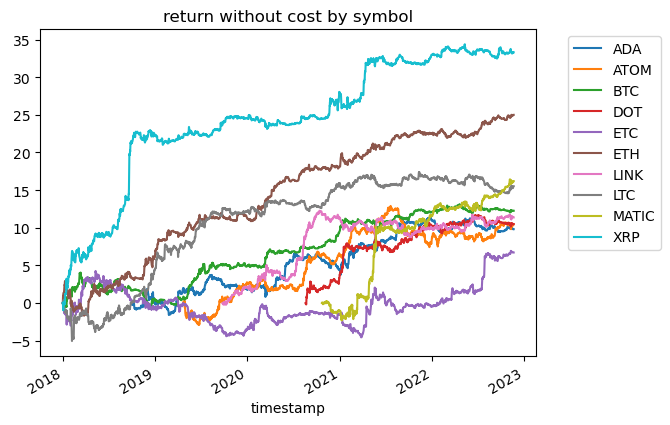

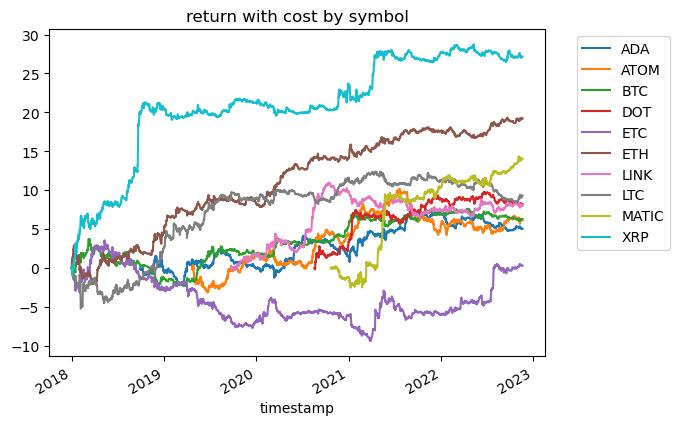

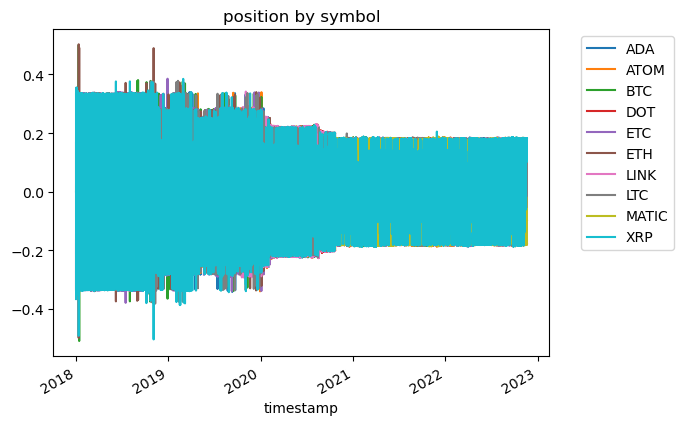

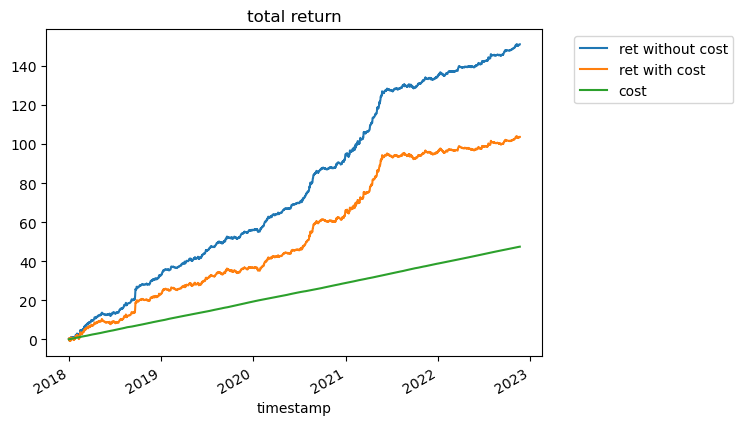

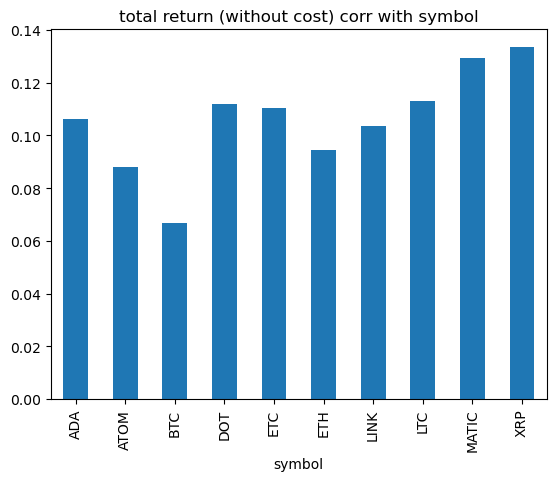

return without cost statistics
mean 0.0033310831737578812
std 0.01585721238627163
sharpe 0.21006738716836285
double sharpe 1.17896491387354
max drawdown 2.091836977275946
min -0.1386933842047274
min sharpe 0.02401760684446793
return with cost statistics
mean 0.0023243759034077384
std 0.0158423777340139
sharpe 0.14671887909964784
double sharpe 0.6781468626278478
max drawdown 3.196593420081257
min -0.1404533842047274
min sharpe 0.01654909147664029


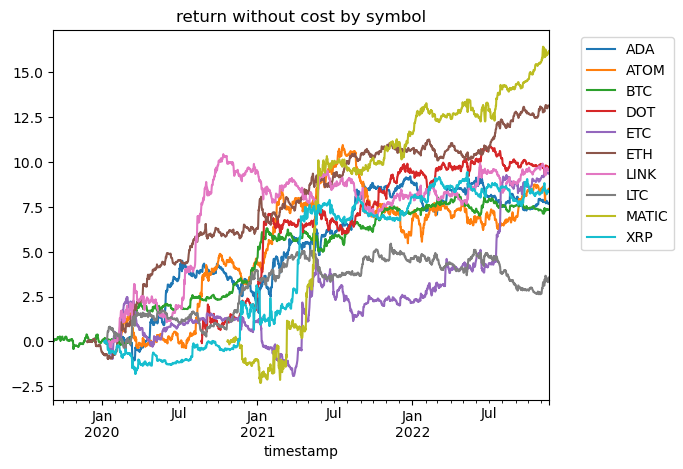

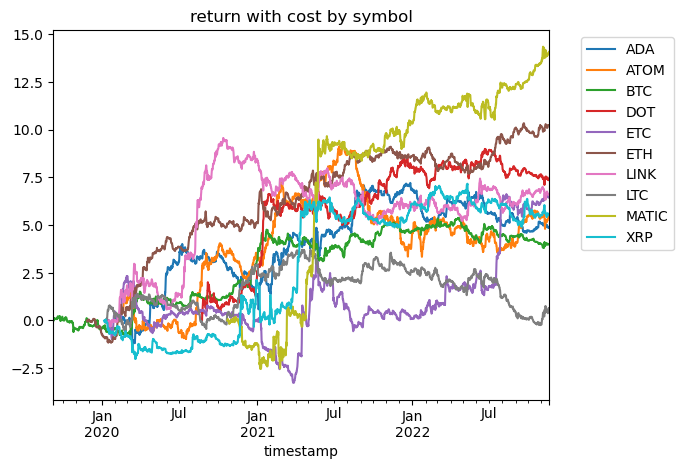

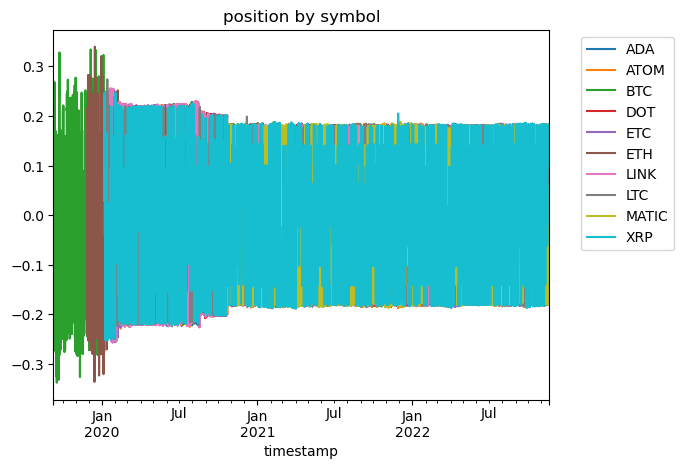

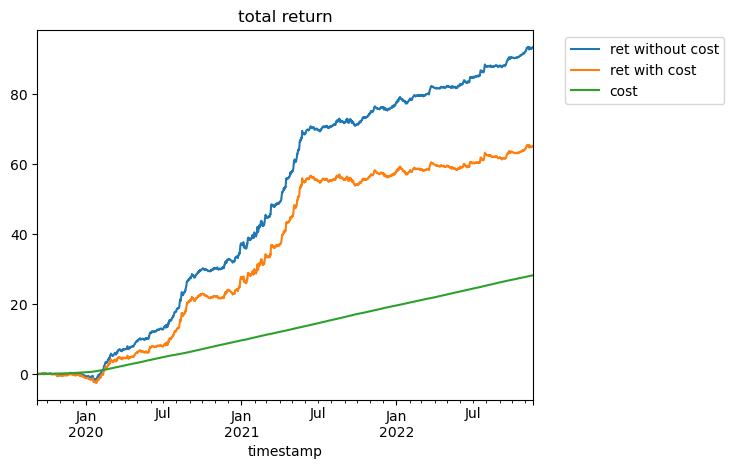

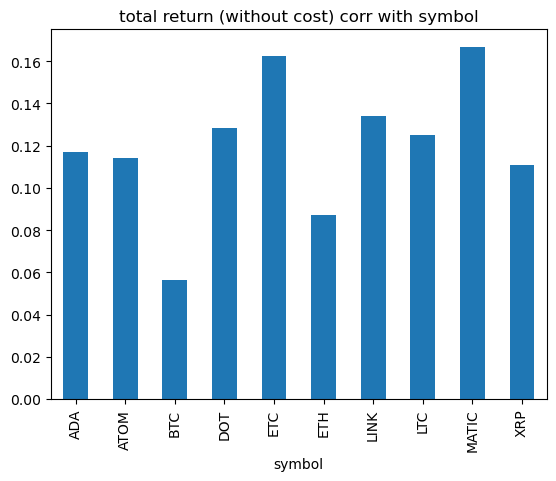

/tmp/ipykernel_12/2508223997.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
/tmp/ipykernel_12/2508223997.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = df.groupby('symbol')['ln_cl_diff'].transform(lambda x: x.rolling(24 * 30, 1).corr(df.loc[x.index, 'ln_cl_diff_mean'])).fillna(0).clip(0.1, 2.0)
/tmp/ipykernel_12/642674334.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.

fit df.shape (345081, 529)


In [5]:
df = pd.read_pickle('/tmp/df_binance_ohlcv_extended.pkl')
df = df.loc[df.index.get_level_values('timestamp') < pd.to_datetime('2022-11-20 00:00:00Z')]
df = df.loc[df.index.get_level_values('timestamp') >= pd.to_datetime('2018-01-01 00:00:00Z')]

df['ret'] = df.groupby('symbol')['twap_5m'].transform(lambda x: x.shift(-25) / x.shift(-1) - 1).fillna(0)
df['execution_start_at'] = df.index.get_level_values('timestamp')

model = ExampleModelRank()

# cv
df_cv = calc_position_cv2(model, df)
visualize_result(df_cv.dropna())
visualize_result(df_cv.loc[~df['extended']].dropna())

# fit and save model as portable format
model.fit(df)
data = cloudpickle.dumps(model)
data = lzma.compress(data)
with open('/home/jovyan/data/{}.xz'.format(model_name), 'wb') as f:
    f.write(data)

expt

- [20220910_beta/20221121_074841.ipynb](20220910_beta/20221121_074841.ipynb) full -SOL,BNB+LTC,ETC
- [20220910_beta/20221121_075040.ipynb](20220910_beta/20221121_075040.ipynb) 2018-01 -SOL,BNB+LTC,ETC
- [20220910_beta/20221121_075237.ipynb](20220910_beta/20221121_075237.ipynb) full -SOL+LTC,ETC
- [20220910_beta/20221121_075303.ipynb](20220910_beta/20221121_075303.ipynb) 2018-01 -SOL+LTC,ETC
- [20220910_beta/20221121_075403.ipynb](20220910_beta/20221121_075403.ipynb) full -SOL
- [20220910_beta/20221121_075339.ipynb](20220910_beta/20221121_075339.ipynb) 2018-01 -SOL

/tmp/ipykernel_12/2508223997.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
/tmp/ipykernel_12/2508223997.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = df.groupby('symbol')['ln_cl_diff'].transform(lambda x: x.rolling(24 * 30, 1).corr(df.loc[x.index, 'ln_cl_diff_mean'])).fillna(0).clip(0.1, 2.0)


timestamp                  symbol
2022-09-21 22:00:00+00:00  ADA      -0.020000
                           ATOM      0.100000
                           BTC       0.140000
                           DOT       0.180000
                           ETC      -0.060000
                                       ...   
2022-11-20 22:00:00+00:00  ETH      -0.098823
                           LINK     -0.178823
                           LTC       0.141177
                           MATIC    -0.018823
                           XRP      -0.058823
Name: position, Length: 14410, dtype: float64
['ADA', 'ATOM', 'BTC', 'DOT', 'ETC', 'ETH', 'LINK', 'LTC', 'MATIC', 'XRP']
test shift predict


/tmp/ipykernel_12/2508223997.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
/tmp/ipykernel_12/2508223997.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = df.groupby('symbol')['ln_cl_diff'].transform(lambda x: x.rolling(24 * 30, 1).corr(df.loc[x.index, 'ln_cl_diff_mean'])).fillna(0).clip(0.1, 2.0)
/tmp/ipykernel_12/2508223997.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame

position1  position2  position3
timestamp                 symbol                                 
2022-09-21 23:00:00+00:00 ADA     -0.036200  -0.036200   0.060000
                          ATOM     0.043800   0.043800  -0.140000
                          BTC     -0.196200  -0.196200  -0.180000
                          DOT      0.163800   0.163800   0.100000
                          ETC      0.003800   0.003800   0.020000
...                                     ...        ...        ...
2022-11-20 21:00:00+00:00 ETH     -0.099172  -0.099172  -0.099172
                          LINK    -0.179172  -0.179172  -0.179172
                          LTC      0.100828   0.100828   0.100828
                          MATIC   -0.019172  -0.019172  -0.019172
                          XRP     -0.059172  -0.059172  -0.059172

[14390 rows x 3 columns]

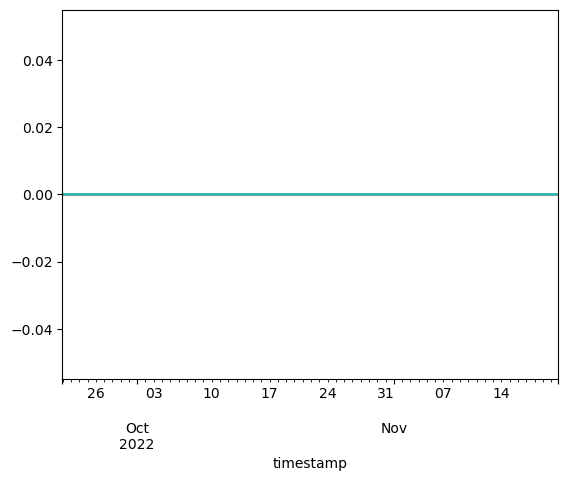

ADA (1439, 4)
ATOM (1439, 4)
BTC (1439, 4)
DOT (1439, 4)
ETC (1439, 4)
ETH (1439, 4)
LINK (1439, 4)
LTC (1439, 4)
MATIC (1439, 4)
XRP (1439, 4)


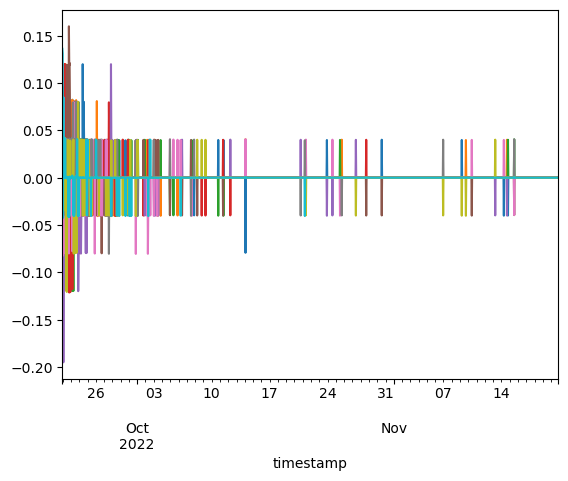

In [6]:
# model validation (Just run this cell in the new kernel to make sure you saved it in a portable format.)

import os
import joblib
import pandas as pd

model = joblib.load('/home/jovyan/data/{}.xz'.format(model_name))
df = pd.read_pickle('/tmp/df_binance_ohlcv_extended.pkl')
df = df[['op', 'hi', 'lo', 'cl', 'volume']]
max_timestamp = df.index.get_level_values('timestamp').max()
df = df.loc[max_timestamp - pd.to_timedelta(model.max_data_sec, unit='S') <= df.index.get_level_values('timestamp')]
print(model.predict(df))
print(model.symbols)



print('test shift predict')
import matplotlib.pyplot as plt

position1 = model.predict(df)
position2 = model.predict(df.loc[df.index.get_level_values('timestamp') < max_timestamp])
position3 = model.predict(df.loc[df.index.get_level_values('timestamp').min() < df.index.get_level_values('timestamp')])

test_timestamp = max_timestamp - pd.to_timedelta(1, unit='H')
df_test = pd.concat([
    position1.rename('position1'),
    position2.rename('position2'),
    position3.rename('position3'),
], axis=1)

df_test = df_test.dropna()
display(df_test)

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    (df_symbol['position2'] - df_symbol['position1']).plot()
plt.show()

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    print(symbol, df_symbol.shape)
    (df_symbol['position3'] - df_symbol['position1']).plot()
plt.show()